# GPT-Q

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pennylane as qml
from pennylane import numpy as np

torch.set_printoptions(precision=3)

In [3]:
qml.__version__

'0.35.0'

Remember the convolution master formula: 


$\frac{2p + w - k}{s} + 1 = d_{out}$

In [4]:
from models import QConv1d

ks = 5  # kind of arbitrary, limited by the number of available qubits
p = (ks - 1) // 2

qconv = QConv1d(kernel_size=ks, out_channels=3, n_qlayers=1, stride=1, padding=p)

/home/ec2-user/environment/gpt-q/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
qconv.draw()

0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤  <Z>
3: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤     
4: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤     

M0 = 
[0.68798962 0.1920832  0.47135085 0.88375711 0.63174977]
M1 = 
[[0.11413384 0.96416001 0.16161325 0.0685922  0.83082469]]


In [6]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[6.888e-01, 6.105e-04, 2.041e-01, 5.558e-01, 4.643e-01, 6.439e-01,
          1.240e-01, 2.507e-01],
         [4.842e-01, 2.038e-01, 7.584e-01, 8.548e-01, 8.633e-01, 8.897e-02,
          5.952e-01, 7.049e-01],
         [5.892e-01, 7.538e-01, 8.009e-01, 4.951e-01, 2.938e-01, 4.290e-02,
          9.473e-01, 5.127e-01],
         [9.441e-01, 6.761e-01, 2.794e-01, 2.256e-01, 9.275e-01, 5.176e-01,
          7.436e-01, 4.512e-01]]])


In [7]:
# here the output has 3 channels
z = qconv(x)
print(z.shape)

torch.Size([1, 4, 8, 3])


In [8]:
# this is a single channel
z[:, :, :, 0].shape

torch.Size([1, 4, 8])

In [9]:
# we can flatten the output
zc = z.view((1, 4, embed_dim*3))
print(zc.shape)

torch.Size([1, 4, 24])


1 + (c*w + 2*p - k) / s = w
=> (c*w - k) / s = w - 1
=> s = (c*w - k) / (w - 1)
this has to be an integer.

n = (c*w - k) / (w - 1) => n * (w - 1) = c*w - k => k = c*w - n * (w - 1)
k = (3 - n) * w + n, 0 < k < 3*w

In [10]:
# to invert the convolution
ks_inv = 3
stride_inv = (3 * embed_dim - ks_inv) // (embed_dim - 1)
print(f"kernel size (=no. of qubits): {ks_inv}")
print(f"stride: {stride_inv}")
qconv_inv = QConv1d(kernel_size=ks_inv, out_channels=1, n_qlayers=1, stride=stride_inv, padding=0)
qconv_inv.draw()

kernel size (=no. of qubits): 3
stride: 3
0: ─╭AngleEmbedding(M0)─╭BasicEntanglerLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├BasicEntanglerLayers(M1)─┤     
2: ─╰AngleEmbedding(M0)─╰BasicEntanglerLayers(M1)─┤     

M0 = 
[0.82112789 0.91236239 0.72302332]
M1 = 
[[0.89164207 0.10621379 0.02582882]]


In [11]:
y = qconv_inv(zc).view((batch_size, seq_len, -1))
print(y.shape)

torch.Size([1, 4, 8])


### Vectorize input to CNN

The code below creates indices for a sliding window of size `kernel_size`. To avoid loops, we can vectorize the operation using Numpy-like operations

In [12]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.800, 0.971, 0.705, 0.466, 0.235, 0.989, 0.965, 0.456],
         [0.942, 0.890, 0.344, 0.925, 0.928, 0.731, 0.398, 0.784],
         [0.137, 0.961, 0.788, 0.650, 0.911, 0.031, 0.206, 0.444],
         [0.132, 0.113, 0.637, 0.263, 0.883, 0.210, 0.060, 0.687]]])


In [13]:
stride = 2
kernel_size = 3
padding = 0

In [14]:
from torch.nn import functional as F

# loops are slow!
out_dim = int((embed_dim + 2 * padding - kernel_size) / stride) + 1
z = F.pad(x, (padding, padding), "constant", 0)
print(z.shape)
print(f"out_dim: {out_dim}\n")
for i in range(batch_size):
    for j in range(seq_len):
        for k in range(0, out_dim):
            k_start = k*stride
            k_end = k_start + kernel_size
            z_slice  = z[i, j, k_start:k_end]
            print(z_slice)
        print('---')

torch.Size([1, 4, 8])
out_dim: 3

tensor([0.800, 0.971, 0.705])
tensor([0.705, 0.466, 0.235])
tensor([0.235, 0.989, 0.965])
---
tensor([0.942, 0.890, 0.344])
tensor([0.344, 0.925, 0.928])
tensor([0.928, 0.731, 0.398])
---
tensor([0.137, 0.961, 0.788])
tensor([0.788, 0.650, 0.911])
tensor([0.911, 0.031, 0.206])
---
tensor([0.132, 0.113, 0.637])
tensor([0.637, 0.263, 0.883])
tensor([0.883, 0.210, 0.060])
---


In [15]:
idx = np.arange(0, kernel_size)
x[:,:,idx]

tensor([[[0.800, 0.971, 0.705],
         [0.942, 0.890, 0.344],
         [0.137, 0.961, 0.788],
         [0.132, 0.113, 0.637]]])

In [16]:
# this creates a square matrix with correct indices
idx = np.expand_dims(np.arange(kernel_size), 0) + np.expand_dims(np.arange(out_dim) * stride, 0).T
print(idx)

[[0 1 2]
 [2 3 4]
 [4 5 6]]


In [17]:
# this should match what is found using loops, but using vectorized indexing
x[:,:,idx]

tensor([[[[0.800, 0.971, 0.705],
          [0.705, 0.466, 0.235],
          [0.235, 0.989, 0.965]],

         [[0.942, 0.890, 0.344],
          [0.344, 0.925, 0.928],
          [0.928, 0.731, 0.398]],

         [[0.137, 0.961, 0.788],
          [0.788, 0.650, 0.911],
          [0.911, 0.031, 0.206]],

         [[0.132, 0.113, 0.637],
          [0.637, 0.263, 0.883],
          [0.883, 0.210, 0.060]]]])

In [18]:
from models import QConv1d

qconv = QConv1d(kernel_size, stride=stride, padding=padding)

In [19]:
out = qconv(x)
print(out.shape)
print(out)

torch.Size([1, 4, 3, 3])
tensor([[[[ 0.020,  0.040,  0.040],
          [-0.180, -0.340, -0.140],
          [ 0.060,  0.060,  0.040]],

         [[ 0.060,  0.000, -0.040],
          [ 0.040,  0.020,  0.100],
          [ 0.000, -0.100, -0.060]],

         [[ 0.140,  0.100,  0.120],
          [-0.320, -0.200, -0.120],
          [-0.160, -0.380, -0.220]],

         [[-0.480, -0.640, -0.460],
          [-0.560, -0.480, -0.440],
          [-0.180, -0.300, -0.100]]]], grad_fn=<ReshapeAliasBackward0>)


## FeedForward

In [20]:
from models import FeedForwardQuantum

embed_dim = 8
n_qubits = 5
n_qlayers = 1
boom_factor = 4
ff = FeedForwardQuantum(embed_dim, boom_factor=boom_factor, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [21]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))

print("input:", x.shape)
xff = ff.forward(x)
print("output:", xff.shape)

input: torch.Size([1, 4, 8])
output: torch.Size([1, 4, 8])


## Attention

In [22]:
batch_size = 1
seq_len = 4
embed_dim = 8
x = torch.rand((batch_size, seq_len, embed_dim))
print(x.shape)
print(x)

torch.Size([1, 4, 8])
tensor([[[0.591, 0.855, 0.877, 0.949, 0.998, 0.049, 0.158, 0.510],
         [0.100, 0.191, 0.937, 0.151, 0.918, 0.341, 0.825, 0.812],
         [0.645, 0.525, 0.927, 0.836, 0.656, 0.865, 0.509, 0.723],
         [0.742, 0.087, 0.442, 0.065, 0.640, 0.883, 0.628, 0.255]]])


In [23]:
from models import MultiHeadAttentionQuantum

n_heads = 2
n_qubits = 5
n_qlayers = 1
n_heads = 4

attn = MultiHeadAttentionQuantum(embed_dim, n_heads, n_qubits, n_qlayers)

In [24]:
out = attn(x)
print("output of attention:", out.shape)

output of attention: torch.Size([1, 4, 8])


## Transformer block

In [25]:
from models import TransformerBlockQuantum

transformer = TransformerBlockQuantum(embed_dim, n_heads=n_heads, n_qubits=n_qubits, n_qlayers=n_qlayers)

In [26]:
x_tf = transformer.forward(x)
print("transformer block output:", x_tf.shape)

transformer block output: torch.Size([1, 4, 8])


## GPT-2 Model

In [27]:
from models import GPT2

embed_dim = 8
batch_size = 1
max_seq_len = 16
src_vocab = 8
tgt_vocab = 4 
n_tlayers = 2
n_heads = 4

gpt2 = GPT2(embed_dim=embed_dim,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            n_heads=n_heads,
            n_tlayers=n_tlayers,
            max_seq_len=max_seq_len)

In [28]:
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
token_ids = torch.tensor(token_ids)
print(token_ids)

tensor([[0, 5, 1, 6, 0, 3, 0, 3, 4, 0, 2, 2, 1, 2, 1, 7]])


In [29]:
inputs = {
    'input_ids': token_ids,
    'attention_mask': torch.ones_like(token_ids),
    'token_type_ids': torch.zeros_like(token_ids)
}

In [30]:
%timeit out = gpt2(inputs)
print("GPT-2 output:", out.shape)

4.64 ms ± 223 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
GPT-2 output: torch.Size([1, 4, 8])


## GPT-Q Model

In [31]:
from models import GPTQ

n_qlayers = 1
#q_device = "default.qubit"
q_device = "lightning.qubit"

gptq = GPTQ(embed_dim=embed_dim,
            src_vocab=src_vocab,
            tgt_vocab=tgt_vocab,
            n_heads=n_heads,
            n_tlayers=n_tlayers,
            max_seq_len=max_seq_len,
            n_qlayers=n_qlayers,
            q_device=q_device)

In [32]:
%timeit out = gptq(inputs)
print("GPT-Q output:", out.shape)

1.62 s ± 22.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GPT-Q output: torch.Size([1, 4, 8])


default.qubit: 6.14 s ± 485 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

lightning.qubit: 1.67 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [33]:
gptq.attn_mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

## Masks

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

from utils import make_padding_mask, make_subsequent_mask, make_lookahead_mask

In [35]:
batch_size = 2
max_seq_len = 4
token_ids = np.random.choice(src_vocab, (batch_size, max_seq_len))
#token_ids = torch.tensor(token_ids)
print(token_ids)

[[1 4 4 5]
 [5 4 7 5]]


In [36]:
make_padding_mask(torch.Tensor(token_ids))

tensor([[[True, True, True, True]],

        [[True, True, True, True]]])

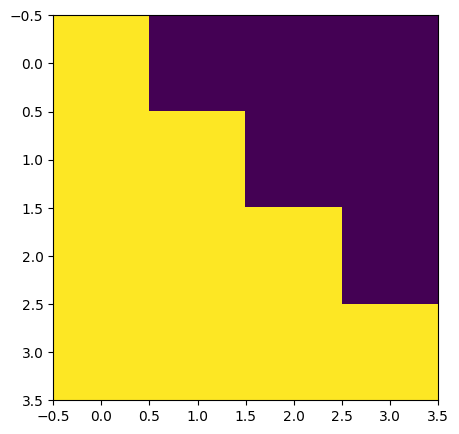

In [37]:
plt.figure(figsize=(5,5))
plt.imshow(make_subsequent_mask(max_seq_len)[0])

In [38]:
from utils import make_lookahead_mask, make_src_mask


token_ids = np.array([
    [1, 2, 3, 0, 0],
    [1, 2, 3, 4, 0]
], dtype=np.int32)
token_ids = torch.from_numpy(token_ids)

print(token_ids)
print(make_src_mask(token_ids.size(1)))

tensor([[1, 2, 3, 0, 0],
        [1, 2, 3, 4, 0]], dtype=torch.int32)
tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


In [39]:
torch.nn.Transformer().generate_square_subsequent_mask(5)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

In [40]:
sz = 5
torch.triu(torch.full((sz, sz), float('-inf')), diagonal=1)

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])

## Train Classifier

In [41]:
from torchtext.datasets import IMDB

In [42]:
train_iter, test_iter = IMDB(split=('train', 'test'))

In [85]:
train_data = []
n_max = 1000
for i, (label, line) in enumerate(train_iter):
    if i >= n_max:
        break
    train_data.append(line)
print(len(train_data))
print(train_data[1])

1000
"I Am Curious: Yellow" is a risible and pretentious steaming pile. It doesn't matter what one's political views are because this film can hardly be taken seriously on any level. As for the claim that frontal male nudity is an automatic NC-17, that isn't true. I've seen R-rated films with male nudity. Granted, they only offer some fleeting views, but where are the R-rated films with gaping vulvas and flapping labia? Nowhere, because they don't exist. The same goes for those crappy cable shows: schlongs swinging in the breeze but not a clitoris in sight. And those pretentious indie movies like The Brown Bunny, in which we're treated to the site of Vincent Gallo's throbbing johnson, but not a trace of pink visible on Chloe Sevigny. Before crying (or implying) "double-standard" in matters of nudity, the mentally obtuse should take into account one unavoidably obvious anatomical difference between men and women: there are no genitals on display when actresses appears nude, and the same

In [86]:
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, decoders, trainers

vocab_size = 300
min_frequency = 2
special_tokens = [
        "<s>",
        "<pad>",
        "</s>",
        "<unk>",
        "<mask>",
    ]

tokenizer = Tokenizer(models.BPE())
tokenizer.normalizer = normalizers.NFKC()
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
tokenizer.decoders = decoders.ByteLevel()

trainer = trainers.BpeTrainer(
    vocab_size=vocab_size,
    initial_alphabet=pre_tokenizers.ByteLevel.alphabet(),
    min_frequency=min_frequency,
    special_tokens=special_tokens)

tokenizer.train_from_iterator(train_data, trainer=trainer)
tokenizer.save("gptq.json")

In [87]:
tokenizer.encode("Hello world").ids

[225, 44, 73, 286, 83, 268, 281, 80, 72]

## Fit IMDb Sentiment Analysis Model

In [120]:
train_data = []
n_max = 100
for i, (label, line) in enumerate(train_iter):
    if i >= n_max:
        break
    token_ids = tokenizer.encode(line).ids
    token_ids = torch.LongTensor(token_ids)
    train_data.append(({'input_ids': token_ids}, label))
train_loader = torch.utils.data.DataLoader(train_data)

print(len(train_data))
print(train_data[1])

100
({'input_ids': tensor([225,   6,  45, 225,  37,  81, 225,  39,  89,  86,  77, 282,  87,  30,
        225,  61,  73, 286,  83,  91,   6, 225, 270, 262, 225,  86, 270,  77,
         70,  80,  73, 290, 287, 267,  88, 280,  88,  77, 282,  87, 265,  88,
         73,  69,  81, 278, 287,  77,  80,  73,  18, 297,  88, 289,  83, 283,
         82,  11,  88, 273, 296,  88, 271, 268, 276,  88, 269,  82,  73,  11,
         87, 287,  83,  80, 277,  77,  71,  69,  80, 225,  90,  77,  73,  91,
         87, 262, 267, 272,  73,  71,  69,  89,  87,  73, 261,  76, 270, 274,
         77,  80,  81, 279, 294, 225, 276,  86,  72,  80,  93, 272,  73, 261,
         69,  79, 280, 265, 271,  77, 282,  87,  80,  93, 269,  82, 262,  82,
         93, 292,  73,  90,  73,  80,  18, 225,  37,  87, 274, 281, 266, 279,
         80,  69,  77,  81, 261, 276,  88, 274,  86, 284,  88,  69,  80, 273,
         69,  80,  73, 225,  82,  89,  72, 277,  93, 225, 270, 262,  82, 262,
         89,  88,  83,  81, 296,  77,  71, 22

In [119]:
from dataset import IMDbDataModule

BATCH_SIZE = 4
max_seq_len = 16
n_examples_max = 16
#n_examples_max = 8 # for quick tests
#n_examples_max = None

dm = IMDbDataModule(val_split=0.2,
                    batch_size=BATCH_SIZE,
                    max_seq_length=max_seq_len,
                    n_examples_max=n_examples_max)
# train_loader = torch.utils.data.DataLoader(train_data)
train_loader = torch.utils.data.DataLoader(train_data)

In [121]:
next(iter(train_loader))

[{'input_ids': tensor([[297, 225, 267,  ...,  83,  88,  18]])}, tensor([1])]

In [122]:
import lightning as L

trainer = L.Trainer(
    max_epochs=10,
    accelerator='auto')

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [129]:
from models import GPT2, IMDbClassifier

embed_dim = 8
vocab_size = 2000
n_tlayers = 1
n_heads = 2
lr = 1e-3

classifier = IMDbClassifier(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_tlayers=n_tlayers,
                       max_seq_len=max_seq_len)

In [130]:
trainer.fit(classifier, train_loader)

/home/ec2-user/environment/gpt-q/venv/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ec2-user/environment/gpt-q/lightning_logs/version_6/checkpoints exists and is not empty.

  | Name    | Type       | Params
---------------------------------------
0 | wte     | Embedding  | 2.4 K 
1 | wpe     | Embedding  | 128   
2 | dropout | Dropout    | 0     
3 | ln_f    | LayerNorm  | 16    
4 | h       | ModuleList | 872   
5 | out     | Linear     | 16.0 K
---------------------------------------
19.4 K    Trainable params
0         Non-trainable params
19.4 K    Total params
0.078     Total estimated model params size (MB)


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 102.20it/s, v_num=6]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 101.30it/s, v_num=6]


In [131]:
torch.save(classifier.state_dict(), "imdb_classifier.pt")

## IMBd Classifier Quantum

In [137]:
from models import GPTQ, IMDbClassifierQuantum

n_qlayers = 1
q_device = 'qulacs.simulator'

classifier_quantum = IMDbClassifierQuantum(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_tlayers=n_tlayers,
                       max_seq_len=max_seq_len,
                       q_device=q_device)

In [ ]:
trainer_quantum = L.Trainer(
    max_epochs=10,
    accelerator='auto')

trainer_quantum.fit(classifier_quantum, train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | wte     | Embedding  | 2.4 K 
1 | wpe     | Embedding  | 128   
2 | dropout | Dropout    | 0     
3 | ln_f    | LayerNorm  | 16    
4 | h       | ModuleList | 51    
5 | out     | Linear     | 16.0 K
---------------------------------------
18.6 K    Trainable params
0         Non-trainable params
18.6 K    Total params
0.074     Total estimated model params size (MB)


Epoch 0:   0%|                                                                                                                                                                                                            | 0/100 [08:48<?, ?it/s]


In [92]:
torch.save(classifier_quantum.state_dict(), "imdb_classifier_quantum.pt")

## Fit Language Model

In [190]:
from models import LanguageModel

In [191]:
vocab_size = 2000
max_seq_len = 64
n_layers = 1
n_heads = 2
lr = 1e-3

model = LanguageModel(embed_dim=embed_dim,
                       vocab_size=vocab_size,
                       n_heads=n_heads,
                       n_layers=n_layers,
                       max_seq_len=max_seq_len)